In [40]:
!pip install catboost


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from pycaret.regression import setup, compare_models
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import missingno as msno

In [42]:
def explore_num(inspection_df, x, figsize=(7.5, 5)):
    temp_df = inspection_df.copy()
    null_count = temp_df[x].isna().sum()
    null_per = null_count * 100 / len(temp_df)
    nunique = temp_df[x].nunique()
    most_common_value = temp_df[x].value_counts(dropna=False).index[0]
    freq = temp_df[x].value_counts(dropna=False).values[0]
    per_common_value = freq * 100 / len(temp_df)

    gridspec = {'height_ratios': [0.7, 0.3]}
    fig, ax = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw=gridspec)

    sns.histplot(data=temp_df, x=x, ax=ax[0])
    sns.boxplot(data=temp_df, x=x, ax=ax[1])

    ax[0].set_title(f"Column: {x}", fontweight='bold', fontsize=15)
    sns.despine()
    fig.tight_layout()
    plt.show()

    print(f'There are {null_count} NaN ({round(null_per, 2)}%)')
    print(f'There are {nunique} unique values')
    print(f'The most common value is {most_common_value}, occurs {freq} times ({round(per_common_value, 2)}%)')

    if per_common_value > 98:
        print(f'{x}: is a constant or quasi-constant feature and should be dropped')
    else:
        print(f'{x}: is neither constant nor a quasi-constant feature and should be kept')

    return fig, ax

def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax


def plot_cat_vs_target(inspection_df , x , y='rating' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax


def plot_num_vs_target(inspection_df ,x,y='rating' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax


# Load dataset

In [43]:
file_path = 'sales_predictions_2023.csv'
df = pd.read_csv(file_path)

# Cleaning Data and Feature Engineering: 

In [44]:
df.duplicated().sum()

0

<Axes: >

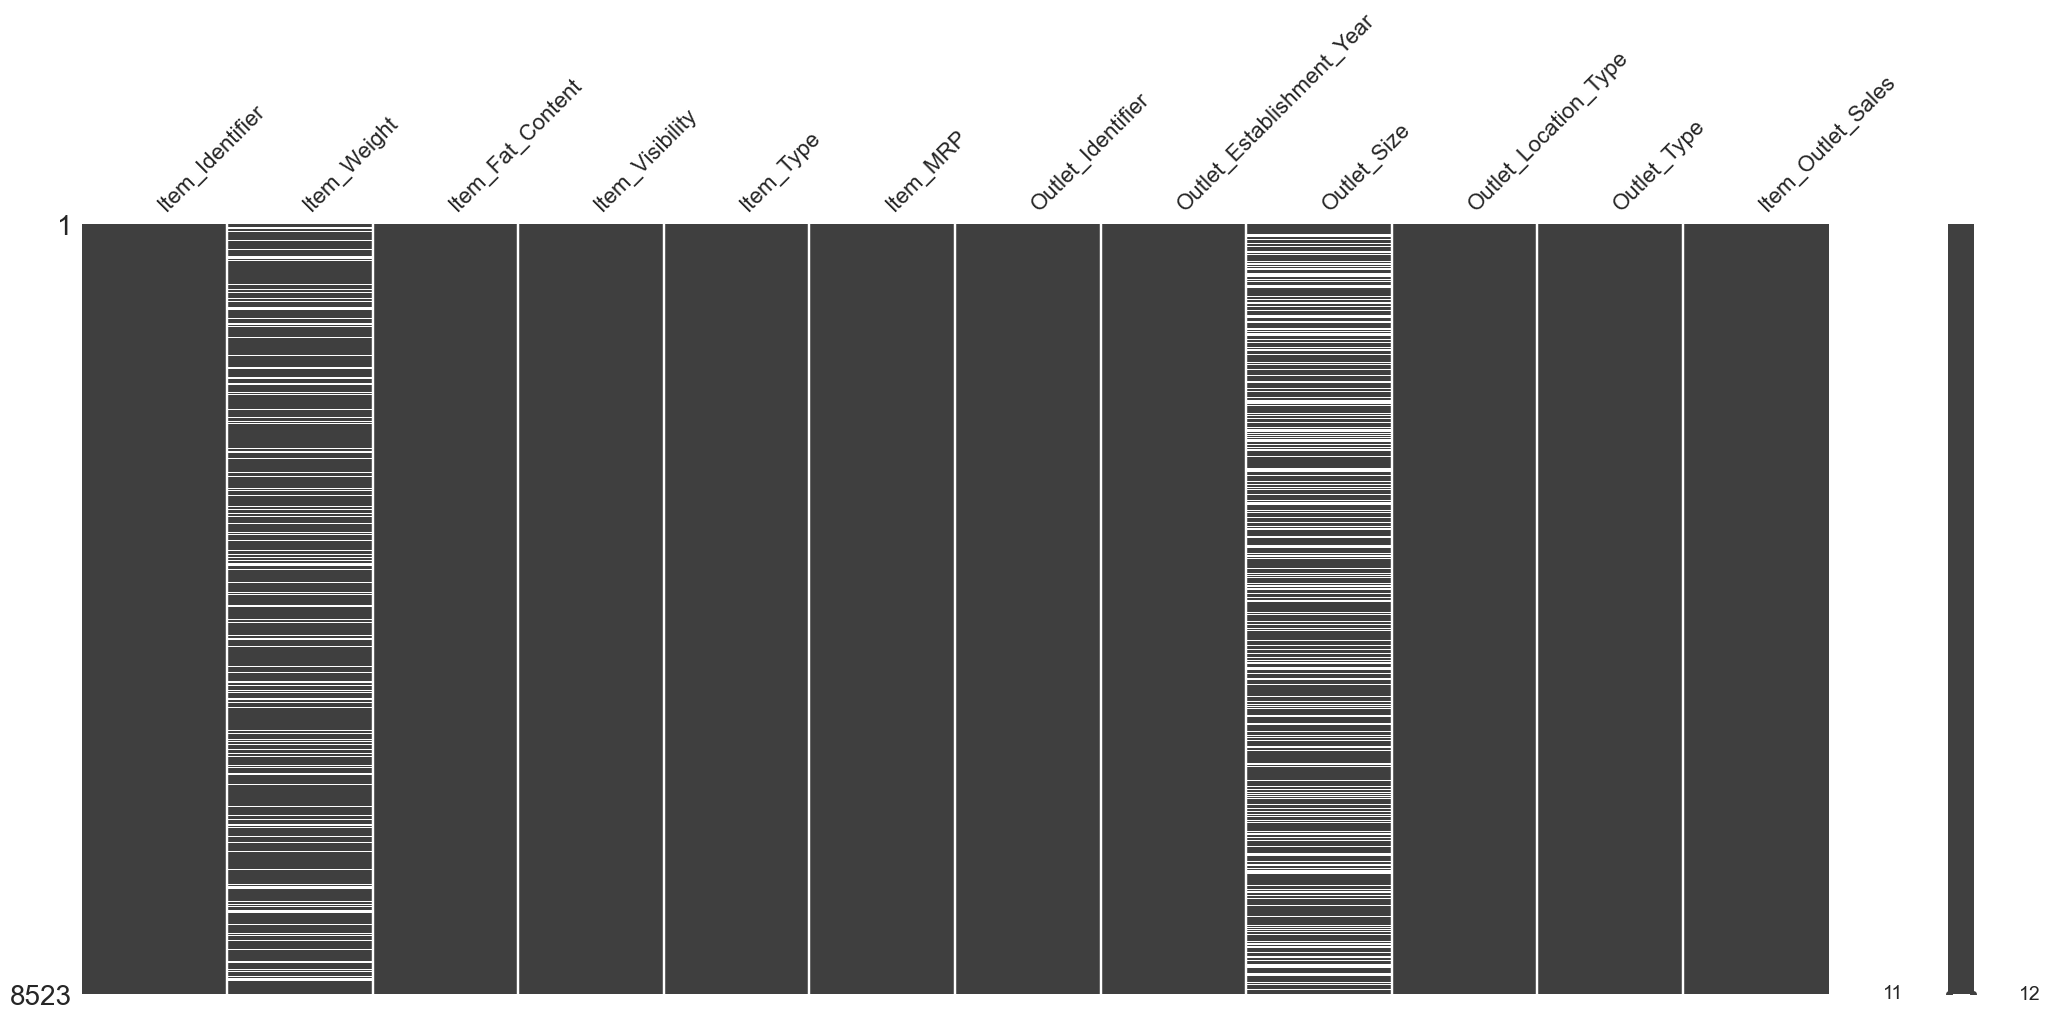

In [45]:
msno.matrix(df)

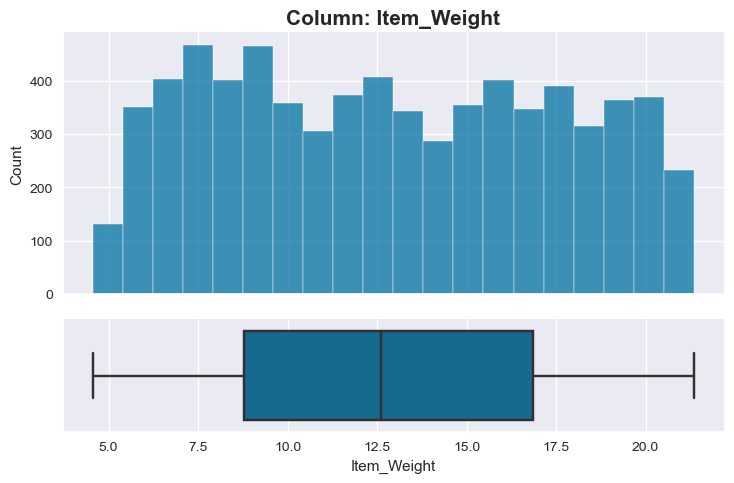

There are 1463 NaN (17.17%)
There are 415 unique values
The most common value is nan, occurs 1463 times (17.17%)
Item_Weight: is neither constant nor a quasi-constant feature and should be kept


In [46]:
# Item Weight
explore_num(df,'Item_Weight');

The data dosen't have a normal distribution so the mean will be biased , that's why we need to impute the missing data with the median .

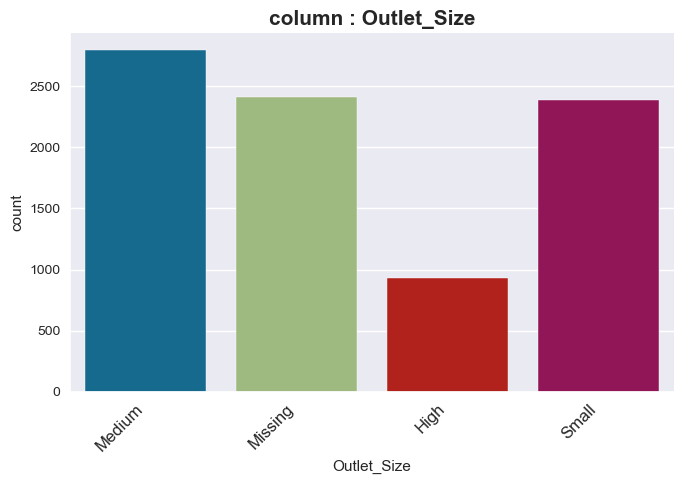

There is 2410 NaN (28.28%)
There is 4 unique values
The most common value is Medium , occurs 2793 times (32.77%)
Outlet_Size: is neither constant or a quasi-constant feauture and should be kept


In [47]:
# Outlet Size
explore_cat(df,'Outlet_Size');

In [48]:
df['Outlet_Age'] = 2024 - df['Outlet_Establishment_Year']

## Replace inconsistent categories in 'Item_Fat_Content'

In [49]:
replacement_map = {'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(replacement_map)

## Defining numerical and categorical columns

In [50]:
num_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [51]:
df[num_cols].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age
count,7060.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,26.17
std,4.64,0.05,62.28,8.37
min,4.56,0.00,31.29,15.00
25%,8.77,0.03,93.83,20.00
50%,12.60,0.05,143.01,25.00
75%,16.85,0.09,185.64,37.00
max,21.35,0.33,266.89,39.00


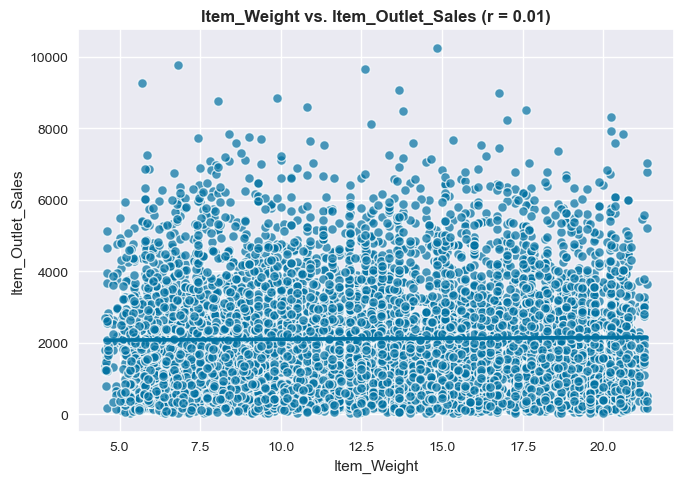

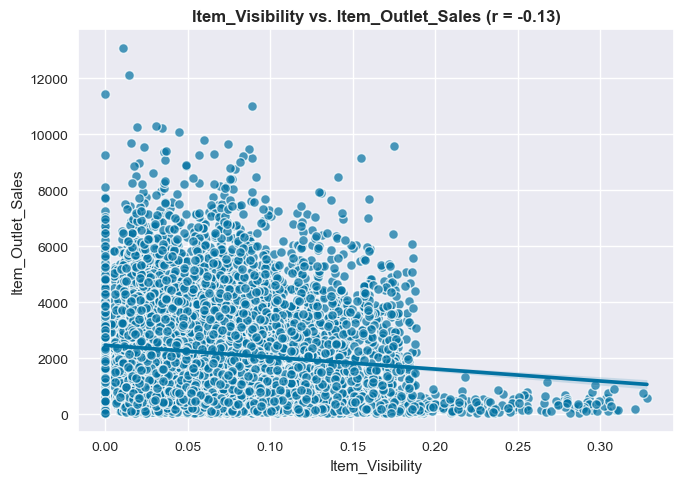

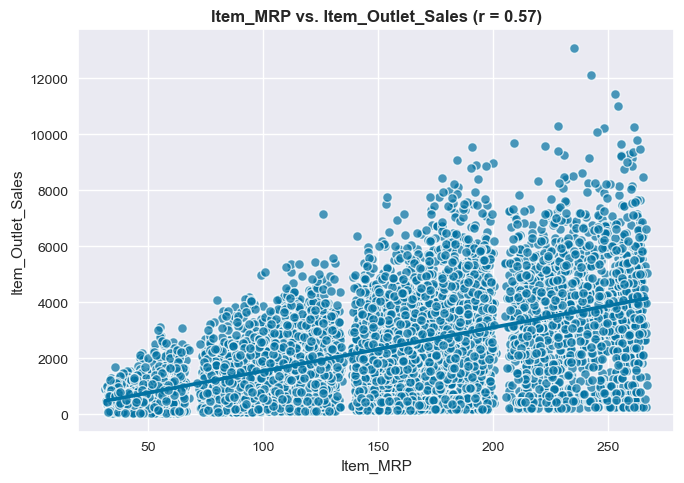

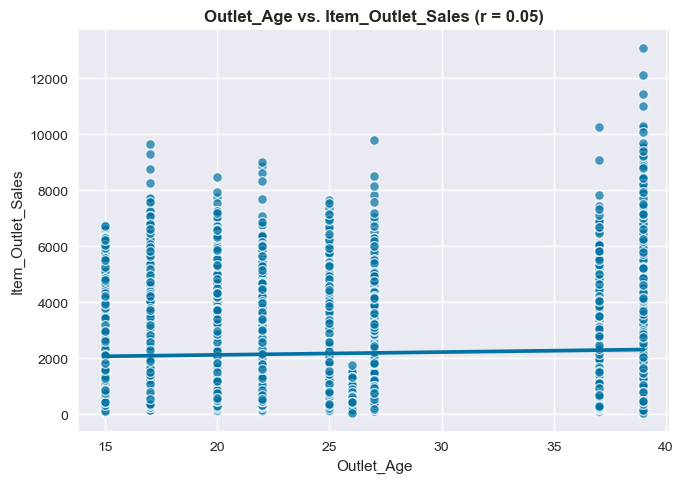

In [52]:
for i in num_cols:
  plot_num_vs_target(df,i,y='Item_Outlet_Sales');


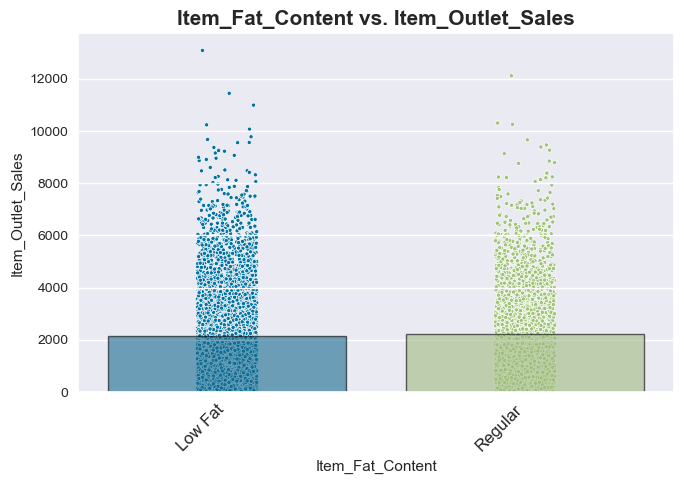

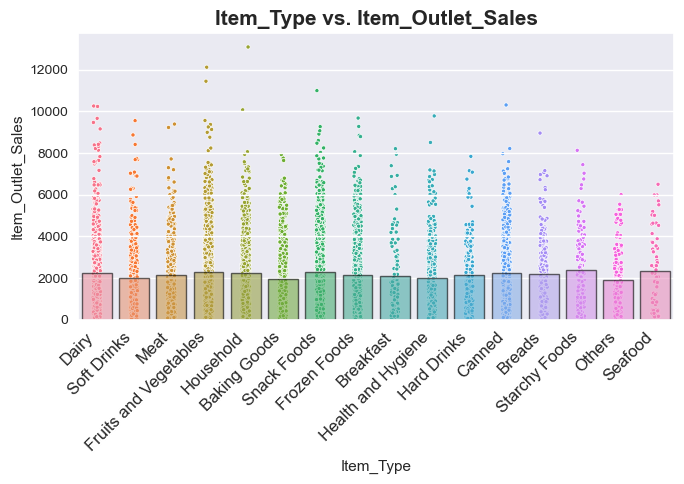

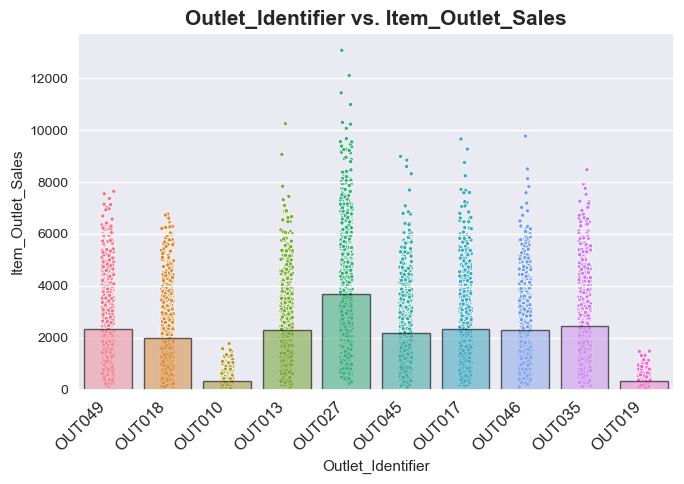

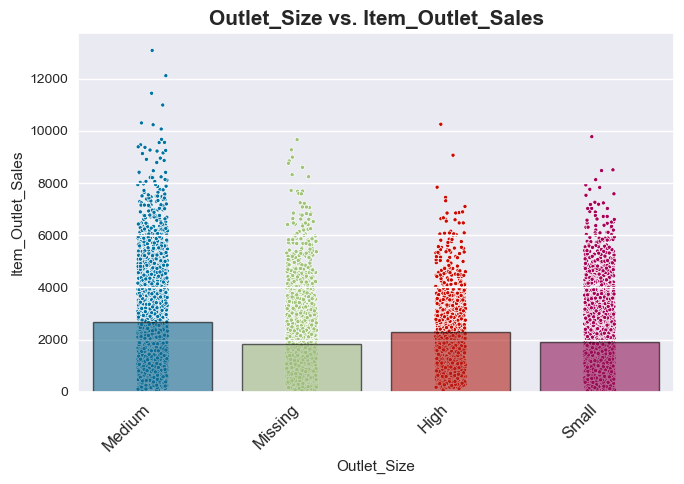

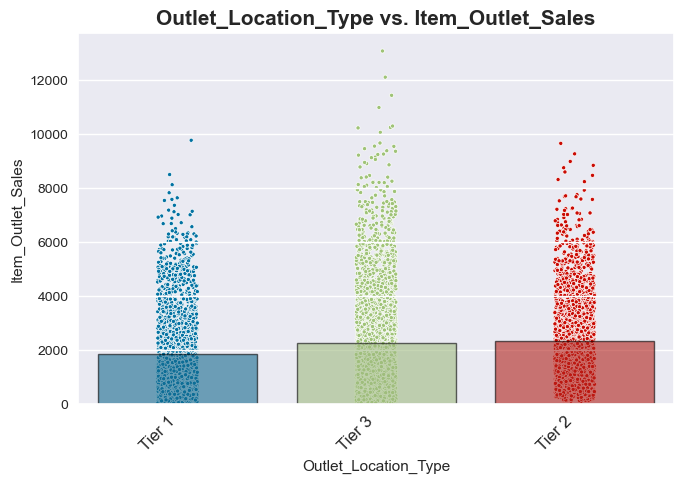

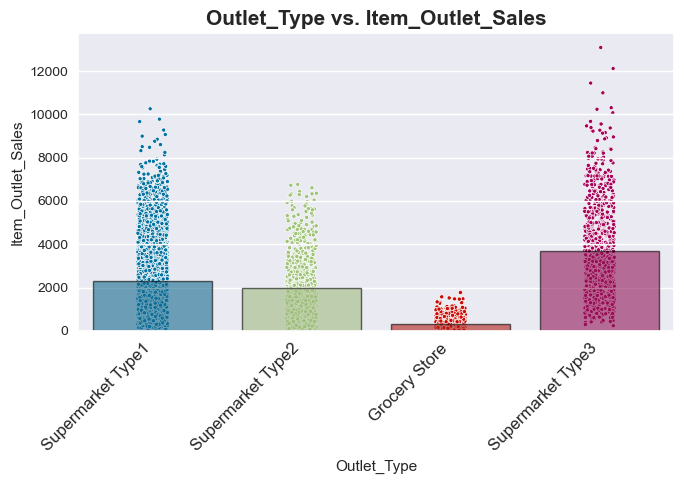

In [53]:
for i in cat_cols:
  plot_cat_vs_target(df,i,y='Item_Outlet_Sales');

In [63]:
df1 = df.groupby(['Outlet_Identifier']).mean()
df1

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Age
Outlet_Identifier,,,,,,
OUT010,12.913153,0.101457,140.777594,1998.0,339.351662,26.0
OUT013,13.006148,0.059957,141.425982,1987.0,2298.995256,37.0
OUT017,12.826668,0.061377,139.421119,2007.0,2340.675263,17.0
OUT018,12.873346,0.061014,141.678634,2009.0,1995.498739,15.0
OUT019,NaN,0.108441,139.787088,1985.0,340.329723,39.0
OUT027,NaN,0.058615,139.801791,1985.0,3694.038558,39.0
OUT035,12.829349,0.061263,143.122481,2004.0,2438.841866,20.0
OUT045,12.649989,0.060474,140.950246,2002.0,2192.384798,22.0
OUT046,12.866801,0.060464,142.057387,1997.0,2277.844267,27.0


In [55]:
df1.isna().sum()

Item_Weight                  2
Item_Visibility              0
Item_MRP                     0
Outlet_Establishment_Year    0
Item_Outlet_Sales            0
Outlet_Age                   0
dtype: int64

# Target and features

In [56]:
target = 'Item_Outlet_Sales'
X = df1.drop(target, axis=1)
y = df1[target]

## Train/Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Missing Data Handling:

### Preprocessing pipelines

In [64]:
num_cols1 = X_train.select_dtypes('number').columns

In [65]:
scaler = StandardScaler()
num_imputer = SimpleImputer(strategy='median')

## Creating the pipeline

In [66]:
num_pipe = make_pipeline(num_imputer, scaler)
transformer = ColumnTransformer(('num', num_pipe, num_cols1))
                                 

## Fit and transform data

In [67]:
X_train_tr = transformer.fit_transform(X_train)
X_test_tr = transformer.transform(X_test)

ValueError: not enough values to unpack (expected 3, got 2)

# Define regression metrics

In [68]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R^2': r2}

# Model comparison using PyCaret

In [70]:
pycaret_setup = setup(data=df1, target='Item_Outlet_Sales')
best_model_pycaret = compare_models()

,Description,Value
0,Session id,5136
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(10, 6)"
4,Transformed data shape,"(10, 6)"
5,Transformed train set shape,"(7, 6)"
6,Transformed test set shape,"(3, 6)"
7,Numeric features,5
8,Rows with missing values,20.0%
9,Preprocess,True


# Train multiple models

In [52]:
xgb_model = XGBRegressor(random_state=42)
linear_reg_model = LinearRegression()
dcr_model = DecisionTreeRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
lgbm_model = LGBMRegressor(random_state=42)

## Fit the models

In [53]:
xgb_model.fit(X_train_tr, y_train)
linear_reg_model.fit(X_train_tr, y_train)
dcr_model.fit(X_train_tr, y_train)
gbr_model.fit(X_train_tr, y_train)
catboost_model.fit(X_train_tr, y_train)
lgbm_model.fit(X_train_tr, y_train)

LGBMRegressor(random_state=42)

# Stacking Regressor (combining models)

In [54]:
stack_reg = StackingRegressor(estimators=[
    ('xgb', xgb_model),
    ('lr', linear_reg_model),
    ('dcr', dcr_model),
    ('gbr', gbr_model),
    ('catboost', catboost_model),
    ('lgbm', lgbm_model)
], final_estimator=RandomForestRegressor(n_estimators=200, random_state=42))

stack_reg.fit(X_train_tr, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                              ('lr', LinearRegression()),
                              ('dcr', DecisionTreeRegressor(random_state=42)),
                              ('gbr',
                               GradientBoostingRegressor(random_state=42)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x000001D1A7040FD0>),
                              ('lgbm', LGBMRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=200,
                                                        random_state=42))

In [55]:
# Evaluation of models

In [56]:
models = [xgb_model, linear_reg_model, dcr_model, gbr_model, catboost_model, lgbm_model, stack_reg]
model_names = ['XGBRegressor', 'LinearRegression', 'DecisionTree', 'GradientBoosting', 'CatBoost', 'LightGBM', 'Stacking']

for model, name in zip(models, model_names):
    print(f"\n{name}:")
    y_train_pred = model.predict(X_train_tr)
    y_test_pred = model.predict(X_test_tr)
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    print(f"Training Metrics: {train_metrics}")
    print(f"Test Metrics: {test_metrics}")


XGBRegressor:
Training Metrics: {'MAE': 947.3000398069428, 'MSE': 1502697.2877313867, 'RMSE': 1225.8455399157704, 'R^2': 0.49199737398103394}
Test Metrics: {'MAE': 1424.0484386775454, 'MSE': 3265739.483122221, 'RMSE': 1807.135712425113, 'R^2': -0.20153622117971004}

LinearRegression:
Training Metrics: {'MAE': 1353.8889359342916, 'MSE': 2938772.2254069163, 'RMSE': 1714.2847562196066, 'R^2': 0.006517134244553802}
Test Metrics: {'MAE': 1328.0514920821113, 'MSE': 2755791.0528495274, 'RMSE': 1660.0575450415952, 'R^2': -0.01391515922023534}

DecisionTree:
Training Metrics: {'MAE': 10.700838433977287, 'MSE': 19924.93509478989, 'RMSE': 141.15571222869406, 'R^2': 0.9932641660871754}
Test Metrics: {'MAE': 1851.4169067741936, 'MSE': 5784416.828884248, 'RMSE': 2405.081459926929, 'R^2': -1.128212116803987}

GradientBoosting:
Training Metrics: {'MAE': 1311.4601588043345, 'MSE': 2756961.7446108535, 'RMSE': 1660.4101133788765, 'R^2': 0.0679800798665603}
Test Metrics: {'MAE': 1331.5025920475744, 'MSE'

In [57]:
## Cross-validation on the best model

In [58]:
cv_scores = cross_val_score(stack_reg, X_train_tr, y_train, cv=5, scoring='r2')
print(f"\nCross-validation R^2 scores for Stacking Regressor: {cv_scores}")
print(f"Mean R^2 score: {cv_scores.mean():.3f}")


Cross-validation R^2 scores for Stacking Regressor: [-0.04238275 -0.02236848 -0.04735405 -0.0313592  -0.05559526]
Mean R^2 score: -0.040
